In [1]:
#!/usr/bin/env python3

import os, math, csv, numpy as np, torch, torch.nn as nn
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec
from sklearn.decomposition import TruncatedSVD

DATA_DIR = os.path.join(os.getcwd(), os.path.pardir, os.path.pardir, os.path.pardir, "external_data", "data", "gt_data")
print(DATA_DIR)
SAL_DIR = os.path.join(os.getcwd(), os.path.pardir, os.path.pardir, os.path.pardir, "external_data", "data")
print(SAL_DIR)

C:\Users\jacob\OneDrive\Documents\GitHub\nlp4neuro\code\plot_results\..\..\..\external_data\data\gt_data
C:\Users\jacob\OneDrive\Documents\GitHub\nlp4neuro\code\plot_results\..\..\..\external_data\data


In [2]:
# ── CONFIGURATION ─────────────────────────────────────────────────────────
fish_num    = 9
hidden_size = 4096
n_drop      = 50
np.random.seed(0)

OUT_DIR  = DATA_DIR
coord_dir = os.path.join(SAL_DIR, 'pc_coords')
os.makedirs(coord_dir, exist_ok=True)

# ── LOAD DATA & SALIENCY ─────────────────────────────────────────────────────
F   = np.load(f"{DATA_DIR}/fish{fish_num}_neural_data_matched.npy")
SAL = np.load(f"{SAL_DIR}/fish{fish_num}_importance.npy")
all_idx       = np.arange(F.shape[0])
sal_sorted    = SAL.argsort()[::-1]
rng = np.random.RandomState(0)

Loaded centroids for Linear from disk.
Loaded centroids for PosEnc from disk.
Loaded centroids for RelPos from disk.
Loaded centroids for Spectral from disk.
Loaded centroids for SparseAE from disk.
Saved C:\Users\jacob\OneDrive\Documents\GitHub\nlp4neuro\code\plot_results\..\..\..\external_data\data\gt_data\pca_centroids_gradient.pdf
Centroid coordinates saved to C:\Users\jacob\OneDrive\Documents\GitHub\nlp4neuro\code\plot_results\..\..\..\external_data\data\pc_coords\centroid_coords.csv


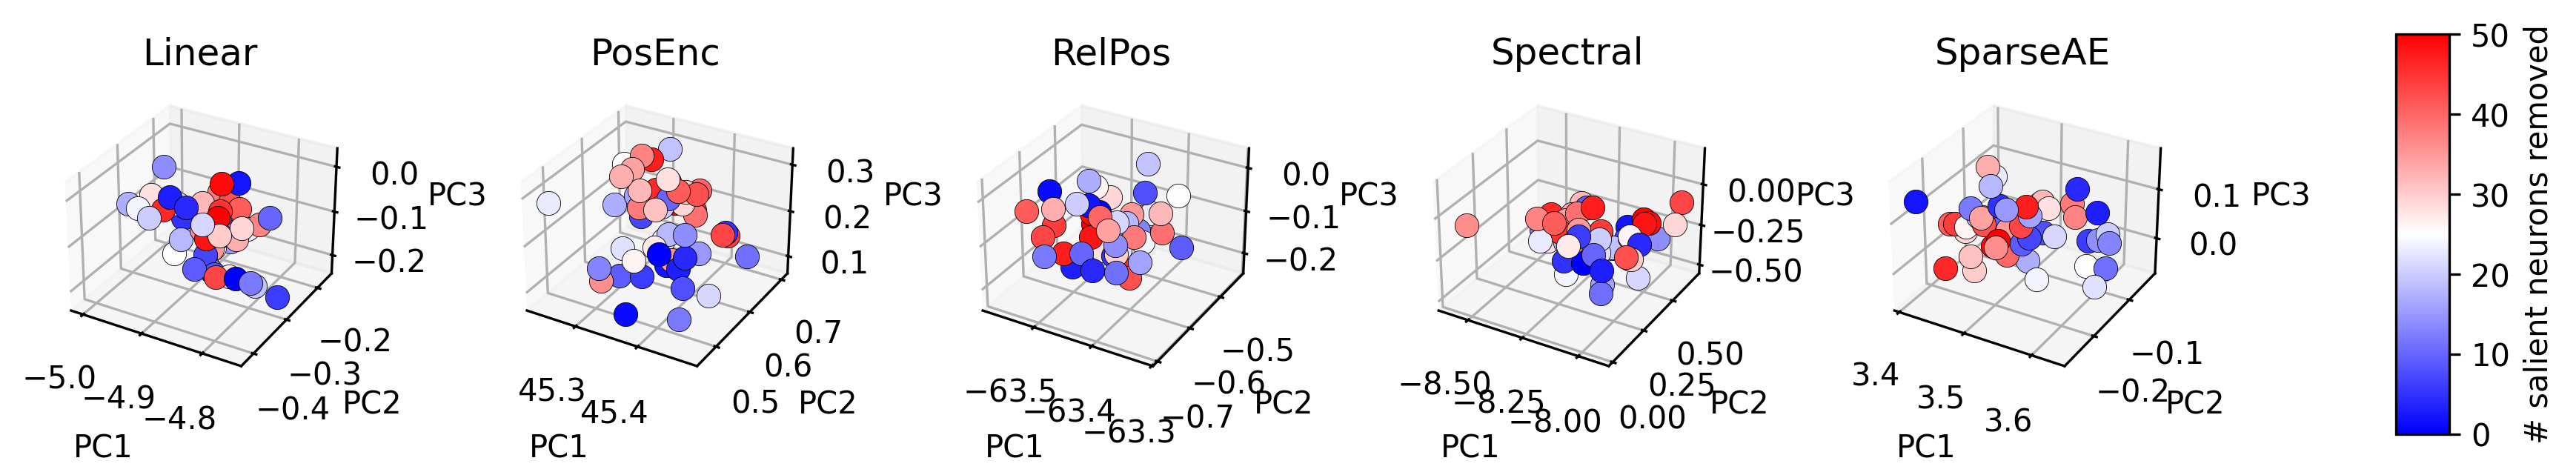

In [3]:
# ── EMBEDDING CLASSES (as before) ───────────────────────────────────────────
class Vanilla(nn.Module):
    def __init__(self,D,H): super().__init__(); self.l=nn.Linear(D,H)
    def forward(self,x): return self.l(x)
class PosEnc(nn.Module):
    def __init__(self,D,H,L=1024):
        super().__init__(); self.l=nn.Linear(D,H)
        pe=torch.zeros(L,H); pos=torch.arange(L).unsqueeze(1)
        div=torch.exp(torch.arange(0,H,2)*(-math.log(10000.0)/H))
        pe[:,0::2],pe[:,1::2]=torch.sin(pos*div),torch.cos(pos*div)
        self.register_buffer('pe',pe.unsqueeze(0),persistent=False)
    def forward(self,x): z=self.l(x); return z+self.pe[:,:z.size(1)]
class RelPos(nn.Module):
    def __init__(self,D,H,R=32):
        super().__init__(); self.l=nn.Linear(D,H); self.R=R; self.rel=nn.Embedding(2*R+1,H)
    def forward(self,x):
        z=self.l(x); B,L,_=z.shape
        offs=torch.arange(L,device=z.device)-torch.arange(L,device=z.device)[0]
        offs=torch.clamp(offs,-self.R,self.R)+self.R
        return z+self.rel(offs).unsqueeze(0).expand(B,L,-1)
class Spectral(nn.Module):
    def __init__(self,D,H): super().__init__(); self.l=nn.Linear(D,H); nn.init.orthogonal_(self.l.weight)
    def forward(self,x): return torch.tanh(self.l(x))
class SparseAE(nn.Module):
    def __init__(self,D,H): super().__init__(); self.enc=nn.Linear(D,H)
    def forward(self,x): B,L,_=x.shape; return torch.relu(self.enc(x.view(B*L,-1))).view(B,L,-1)

def get_embeddings(D):
    return {
        "Linear":   Vanilla(D,hidden_size),
        "PosEnc":   PosEnc(D,hidden_size),
        "RelPos":   RelPos(D,hidden_size),
        "Spectral": Spectral(D,hidden_size),
        "SparseAE": SparseAE(D,hidden_size)
    }
order = ["Linear","PosEnc","RelPos","Spectral","SparseAE"]

# helper to tensor tokens
def tokens(idx):
    return torch.tensor(F[idx].T, dtype=torch.float32).unsqueeze(1)

# ── COMPUTE OR LOAD CENTROIDS ───────────────────────────────────────────────
centroids = {}  # embedding -> array[51×3]

for emb_name in order:
    coord_file = os.path.join(coord_dir, f"{emb_name}_centroids.npy")
    if os.path.exists(coord_file):
        centroids[emb_name] = np.load(coord_file)
        print(f"Loaded centroids for {emb_name} from disk.")
        continue

    print(f"Computing centroids for {emb_name}...")
    # determine baseline subset to fit PCA basis (e.g. random removal k=0)
    rand_drop = rng.choice(all_idx, n_drop, replace=False)
    keep0     = np.setdiff1d(all_idx, rand_drop)
    base_tok  = tokens(keep0)

    # instantiate embedding and PCA basis
    E     = get_embeddings(keep0.size)[emb_name].eval()
    with torch.no_grad():
        Zb = E(base_tok).squeeze(1).cpu().numpy()
    svd   = TruncatedSVD(n_components=3, random_state=0).fit(Zb)

    # compute centroids for k=0..n_drop
    C = np.zeros((n_drop+1, 3), dtype=float)
    for k in range(n_drop+1):
        drop_sal   = sal_sorted[:k]
        candidates = np.setdiff1d(all_idx, drop_sal)
        drop_rand  = rng.choice(candidates, n_drop-k, replace=False)
        keep_idx   = np.setdiff1d(all_idx, np.concatenate([drop_sal, drop_rand]))
        with torch.no_grad():
            Zk = svd.transform(E(tokens(keep_idx)).squeeze(1).cpu().numpy())
        C[k] = Zk.mean(0)
    centroids[emb_name] = C
    np.save(coord_file, C)
    print(f"Saved centroids for {emb_name} to {coord_file}.")

# ── PLOT CENTROIDS WITH BLUE→RED GRADIENT ───────────────────────────────────
fig = plt.figure(figsize=(12,6), dpi=300)
gs  = gridspec.GridSpec(1, len(order)+1, width_ratios=[1]*len(order)+[0.05], wspace=0.6)
axes = [fig.add_subplot(gs[i], projection='3d') for i in range(len(order))]
cax  = fig.add_axes([0.92,0.35,0.02,0.3])

for idx, emb_name in enumerate(order):
    C = centroids[emb_name]
    ax = axes[idx]
    for k in range(n_drop+1):
        color = plt.cm.bwr(k/n_drop)
        ax.scatter(*C[k], c=[color], s=60, edgecolor='k', linewidth=0.2)
    ax.set_title(emb_name)
    ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
    pts = C
    mr = np.ptp(pts, axis=0).max()/2.0
    mid= pts.min(0) + np.ptp(pts,axis=0)/2.0
    for d,m in zip('xyz', mid): getattr(ax, f'set_{d}lim')(m-mr, m+mr)

import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=0, vmax=n_drop)
cbar = mpl.colorbar.ColorbarBase(cax, cmap='bwr', norm=norm)
cbar.set_label('# salient neurons removed')

fig.subplots_adjust(left=0.04, right=0.9, top=0.95, bottom=0.05)
out = os.path.join(OUT_DIR, 'pca_centroids_gradient.pdf')
fig.savefig(out, transparent=True)
print('Saved', out)

# ── CSV OUTPUT ──────────────────────────────────────────────────────────────
csv_file = os.path.join(coord_dir, 'centroid_coords.csv')
with open(csv_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['embedding','k_salient','pc1','pc2','pc3'])
    for emb_name in order:
        for k,coords in enumerate(centroids[emb_name]):
            writer.writerow([emb_name, k, *coords])
print('Centroid coordinates saved to', csv_file)


Saved PCA plots with weighted WD annotations to C:\Users\jacob\OneDrive\Documents\GitHub\nlp4neuro\code\plot_results\..\..\..\external_data\data\gt_data\pca_centroids_gradient.pdf


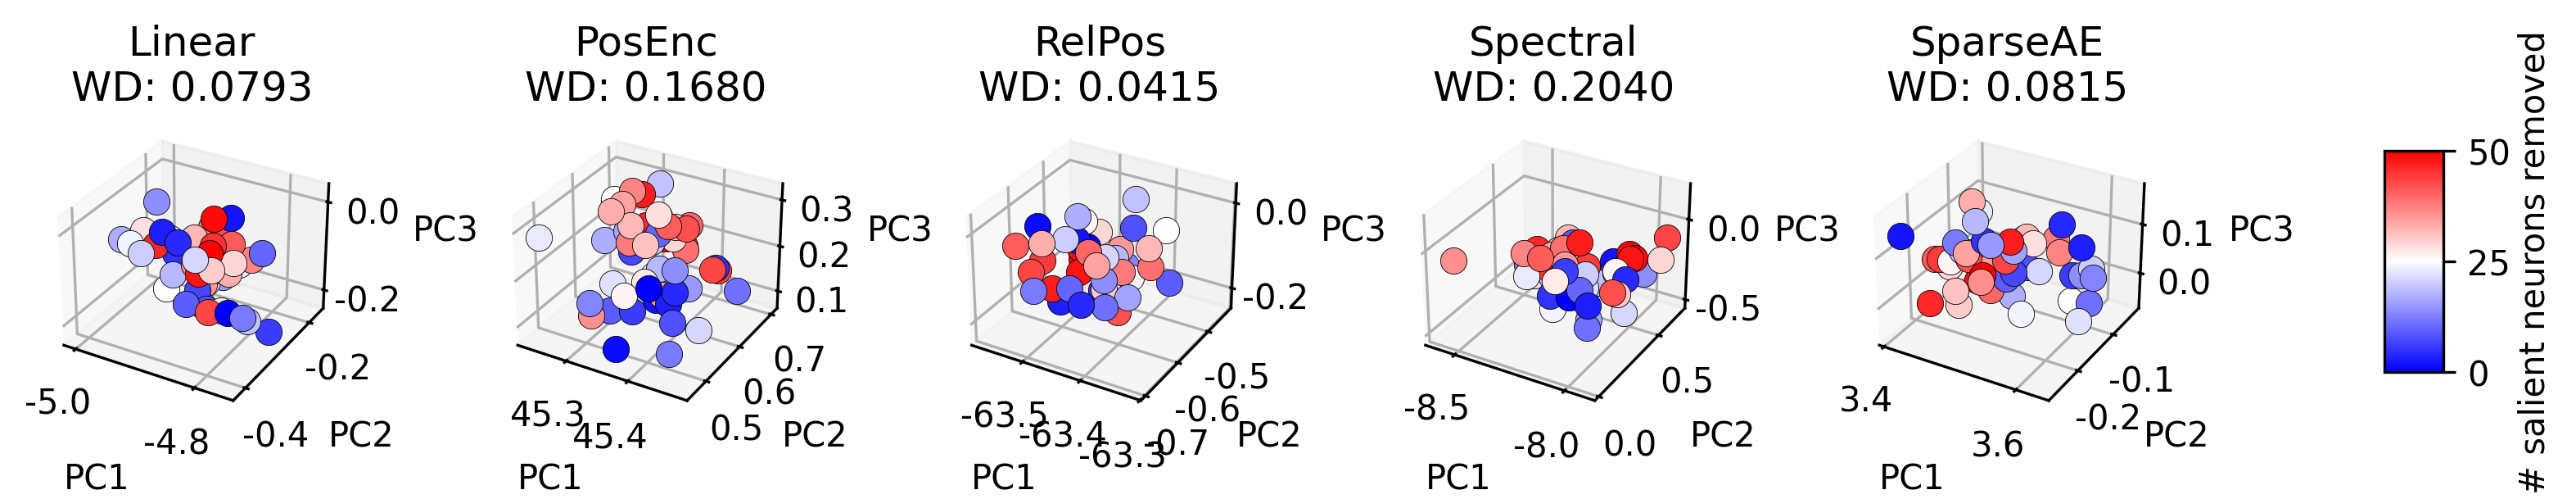

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import wasserstein_distance
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter

# ── PLOT CENTROIDS WITH BLUE→RED GRADIENT ───────────────────────────────────
fig = plt.figure(figsize=(12,6), dpi=300)
gs  = gridspec.GridSpec(1, len(order)+1,
                        width_ratios=[1]*len(order)+[0.05],
                        wspace=0.6)
axes = [fig.add_subplot(gs[i], projection='3d')
        for i in range(len(order))]

# make colorbar half height and centered vertically
cax = fig.add_axes([0.92, 0.425, 0.02, 0.15])

threshold = 25
n_total   = n_drop + 1

# precompute weights for group1 and group2
w1_raw = np.array([(threshold - k)/threshold for k in range(threshold)])
w1     = w1_raw / w1_raw.sum()
n2     = n_total - threshold
w2_raw = np.array([(k - threshold)/(n2 - 1) for k in range(threshold, n_total)])
w2     = w2_raw / w2_raw.sum()

for idx, emb_name in enumerate(order):
    C   = centroids[emb_name]       # shape (n_total, 3)
    ax  = axes[idx]

    g1 = C[:threshold]
    g2 = C[threshold:]

    # weighted 1D Wasserstein on each PC axis
    wd_axes = []
    for dim in range(3):
        u = g1[:, dim]
        v = g2[:, dim]
        wd_axes.append(
            wasserstein_distance(u, v, u_weights=w1, v_weights=w2)
        )
    wd = sum(wd_axes)

    # scatter trajectory
    for k in range(n_total):
        color = plt.cm.bwr(k / (n_total-1))
        ax.scatter(*C[k], c=[color],
                   s=60, edgecolor='k', linewidth=0.2)

    # bring title closer to axes
    ax.set_title(f"{emb_name}\nWD: {wd:.4f}", pad=5)

    # axis labels
    ax.set_xlabel('PC1', labelpad=1)
    ax.set_ylabel('PC2', labelpad=1)
    ax.set_zlabel('PC3', labelpad=1)

    # bring tick labels in closer
    ax.tick_params(axis='x', pad=0)
    ax.tick_params(axis='y', pad=0)
    ax.tick_params(axis='z', pad=0)

    # format tick labels to one decimal place
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    # cubic aspect ratio
    pts = C
    mr  = np.ptp(pts, axis=0).max() / 2.0
    mid = pts.min(0) + np.ptp(pts, axis=0)/2.0
    for dim, m in zip(('x','y','z'), mid):
        getattr(ax, f'set_{dim}lim')(m-mr, m+mr)

# colorbar with only 0,25,50 ticks
norm = mpl.colors.Normalize(vmin=0, vmax=n_drop)
cbar = mpl.colorbar.ColorbarBase(cax, cmap='bwr', norm=norm)
cbar.set_label('# salient neurons removed', labelpad=2)
cbar.set_ticks([0, 25, 50])
cbar.set_ticklabels(['0', '25', '50'])

# fig.subplots_adjust(left=0.04, right=0.9, top=0.95, bottom=0.05)
out_path = os.path.join(OUT_DIR, 'pca_centroids_gradient.pdf')
fig.savefig(out_path, bbox_inches='tight' ,transparent=True)
print(f"Saved PCA plots with weighted WD annotations to {out_path}")
